In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Import Dataset
Import dataset and organize features. Does both COMPAS and Adult results.

In [2]:
dataset_used = 'adult' # adult, compas
algorithm_used = 'postprocessing' # preprocessing, inprocessing, postprocessing
constraint_used = 'dp' # dp, eo

unfair_df = pd.read_csv('./../../predicted_data/unfair_logreg_{}.csv'.format(dataset_used)) ### MODEL IS IN THE POSTPROCESSING NOTEBOOK ### 
df = pd.read_csv('./../../predicted_data/{}/{}_logreg_{}_{}.csv'.format(
    algorithm_used, algorithm_used, dataset_used, constraint_used))

In [5]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,...,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,predictions,Income Binary
0,0,5426,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,1,577,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
2,2,15871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
3,3,4321,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,4,2326,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0


In [4]:
if(dataset_used == 'adult'):
    sensitive_features_test = df.pop('sex')
    sensitive_features_test = sensitive_features_test.replace(0, 'Female')
    sensitive_features_test = sensitive_features_test.replace(1, 'Male')
    y_test = df.pop('Income Binary')
    X_test = df

    unfair_sensitive_features_test = unfair_df.pop('sex')
    unfair_sensitive_features_test = unfair_sensitive_features_test.replace(0, 'Female')
    unfair_sensitive_features_test = unfair_sensitive_features_test.replace(1, 'Male')
    unfair_y_test = unfair_df.pop('Income Binary')
    unfair_X_test = unfair_df

elif(dataset_used == 'compas'):
    sensitive_features_test = df.pop('race')
    sensitive_features_test = sensitive_features_test.replace(0, 'African-American')
    sensitive_features_test = sensitive_features_test.replace(1, 'Caucasian')
    y_test = df.pop('two_year_recid')
    X_test = df

    unfair_sensitive_features_test = unfair_df.pop('sex')
    unfair_sensitive_features_test = unfair_sensitive_features_test.replace(0, 'African-American')
    unfair_sensitive_features_test = unfair_sensitive_features_test.replace(1, 'Caucasian')
    unfair_y_test = unfair_df.pop('two_year_recid')
    unfair_X_test = unfair_df

# Graph Results
We graph the results of the classifiers w.r.t. the fairness constraints:

- Demographic Parity (DP): $P\ [\ h(X)=\hat{y}\ |\ A=a] = P\ [\ h(X)=\hat{y}\ ] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P\ [\ h(X)=\hat{y}\ |\ A=a, Y=y] = P\ [\ h(X)=\hat{y}\ |\ Y=y\ ] \qquad \forall a, \hat{y}$

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, dataset, y=None, description=None, plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    positive_outcome = 'recidivism' if dataset=='compas' else 'income>50k'
    plt.ylabel("P[{} predicted | conditions]".format(positive_outcome))
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])
        print("P[{} predicted | {}]                {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), recidivism_pct[group]))
    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])
            print("P[{} predicted | {}, recidivism]    {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)) , prob_1))
            print("P[{} predicted | {}, no recidivism] {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), prob_0))

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} {}".format(group, positive_outcome), "{} no {}".format(group, positive_outcome)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

# Fairness-Unaware Model
These are results with standard logistic regression without any added fairness constraints. The first graph shows the ratio of the positive outcome $Y$ (income > 50k for Adult, recidivism for COMPAS) in the original dataset. The second graph shows how well the fairness-unaware model does w.r.t. the fairness constraints.


original test data:
P[income>50k predicted | Female]                = 0.10865561694290976
P[income>50k predicted | Male]                  = 0.31234643734643736

fairness-unaware prediction on adult data:
P[income>50k predicted | Female]                = 0.22406384284837325
P[income>50k predicted | Female, recidivism]    = 0.519774011299435
P[income>50k predicted | Female, no recidivism] = 0.18801652892561985
P[income>50k predicted | Male]                  = 0.5942874692874693
P[income>50k predicted | Male, recidivism]      = 0.7925270403146509
P[income>50k predicted | Male, no recidivism]   = 0.5042429656096472


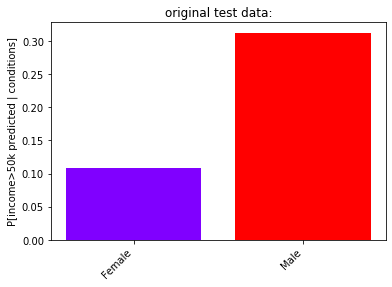

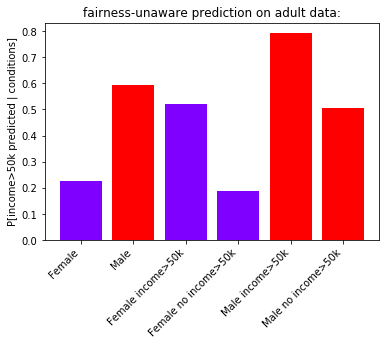

In [6]:
show_proportions(X_test, sensitive_features_test, y_test, dataset_used, description="original test data:", plot_row_index=3)
show_proportions(X_test, sensitive_features_test, unfair_df['predictions'], dataset_used, y_test, description="fairness-unaware prediction on {} data:".format(dataset_used), plot_row_index=4)

# Fairness-Aware Model
Then, we plot the results of our fair model (preprocessing, inprocessing, postprocessing), w.r.t. a certain fairness constraint (Demographic Parity, Equalized Odds).


dp with postprocessing model on adult data:
P[income>50k predicted | Female]                = 0.12093308778391651
P[income>50k predicted | Female, recidivism]    = 0.3389830508474576
P[income>50k predicted | Female, no recidivism] = 0.0943526170798898
P[income>50k predicted | Male]                  = 0.11885749385749386
P[income>50k predicted | Male, recidivism]      = 0.26450344149459193
P[income>50k predicted | Male, no recidivism]   = 0.052702099151406875


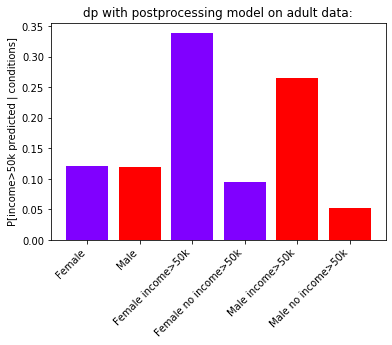

In [7]:
show_proportions(X_test, sensitive_features_test, df['predictions'], dataset_used, y_test, description="{} with {} model on {} data:".format(constraint_used, algorithm_used, dataset_used), plot_row_index=2)